In [1]:
import os, sys, time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mvpa2.suite as mvpa2
import itertools

from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

TR = 2.3

brands = np.array(['abercrombie-fitch','adobe','apple','axe','beats',
          'campina','dell','disney','durex','heineken','kelloggs',
          'microsoft','pampers','redbull'])

cat_names = ['party','work','sex','family']

sns.reset_orig()
plt.rc('font', family='Arial', size=16)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the const

In [2]:
method = 'normalized_common'
r = 'picture_thresh2'

file_path = '../output/'+method+'/'+r.replace("picture","brand")

subj_brand_ds = {}
allsubjs = np.array(range(4,42))

for subj in allsubjs:
    subj_brand_ds[subj] = mvpa2.Dataset.from_hdf5(file_path+'/S'+str(subj)+'.h5py')

In [3]:
tp = 6

rdm_dataset = mvpa2.Dataset(np.zeros((14*37,112)))
rdm_dataset.sa['subj'] = [0 for i in range(len(rdm_dataset))]
rdm_dataset.sa['brand'] = [0 for i in range(len(rdm_dataset))]

subj_neural_rdm = []

idx = 0
for subj in allsubjs[allsubjs != 8]:
    brand_ds = subj_brand_ds[subj]

    rdm_file =  '../mds/S'+str(subj)+'_mds.mat'
    behave_rdm = np.ravel(sp.io.loadmat(rdm_file)['estimate_dissimMat_ltv'])

    neural_rdm = []
    for b in range(14):
        rdm_dataset.samples[idx,:]=np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa['t012_rsa']),axis=0)
        rdm_dataset.sa.subj[idx] = subj
        rdm_dataset.sa.brand[idx] = b
        idx += 1

In [4]:
brand_equity = np.loadtxt('../survey/post/brand_equity.csv',delimiter=',')
brand_equity[:,-1] = 100 - brand_equity[:,-1]
brand_preference = np.mean(brand_equity[:,2:7],axis=1)
brand_association = np.mean(brand_equity[:,7:12],axis=1)

brand_preference_avg = [np.mean(brand_preference[brand_equity[:,1]==b]) for b in range(14)]
brand_association_avg = [np.mean(brand_association[brand_equity[:,1]==b]) for b in range(14)]

for b in range(14):
    print brands[b], '\t', brand_preference_avg[b], brand_association_avg[b]

abercrombie-fitch 	38.1579617834 62.3859872611
adobe 	56.8917197452 51.2891719745
apple 	66.374522293 83.4904458599
axe 	39.0318471338 76.0904458599
beats 	40.1337579618 69.1796178344
campina 	53.3732484076 67.7961783439
dell 	33.0407643312 54.0356687898
disney 	52.7171974522 80.7388535032
durex 	72.4433121019 80.501910828
heineken 	53.7681528662 84.8815286624
kelloggs 	42.298089172 63.0535031847
microsoft 	62.625477707 71.3095541401
pampers 	55.9681528662 67.7681528662
redbull 	39.2496815287 82.4318471338


In [63]:
import itertools
all_res = []
for i in itertools.combinations(high_brand,2):
    clf = mvpa2.LinearCSVMC(space='brand')
    cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='subj'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
    res = cv(rdm_dataset[(rdm_dataset.sa.brand == i[0]) | (rdm_dataset.sa.brand == i[1])])
    print np.mean(res)
    all_res.append(np.mean(res))
print np.mean(all_res)

0.716216216216
0.567567567568
0.635135135135
0.581081081081
0.567567567568
0.567567567568
0.605855855856


In [6]:
def zscore(data):
    return (data-np.nanmean(data))/np.nanstd(data)

In [7]:
output = np.zeros((38*91,6)) * np.nan
subj_behave = []
for subj in allsubjs[allsubjs != 8]:
    brand_ds = subj_brand_ds[subj]

    rdm_file =  '../mds/S'+str(subj)+'_mds.mat'
    behave_rdm = np.ravel(sp.io.loadmat(rdm_file)['estimate_dissimMat_ltv'])
    subj_behave.append(zscore(behave_rdm))
subj_behave = np.array(subj_behave)
z = np.nanmean(subj_behave,axis=0)

f_matrix = []
import itertools
all_res = []
for i in itertools.combinations(range(14),2):
    clf = mvpa2.LinearCSVMC(space='brand')
    cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='subj'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
    res = cv(rdm_dataset[(rdm_dataset.sa.brand == i[0]) | (rdm_dataset.sa.brand == i[1])])
    print np.mean(res)
    all_res.append(np.mean(res))
    f_matrix.append(brand_association_avg[i[0]]*brand_association_avg[i[1]])

0.472972972973
0.5
0.621621621622
0.513513513514
0.472972972973
0.486486486486
0.527027027027
0.527027027027
0.581081081081
0.459459459459
0.5
0.5
0.378378378378
0.581081081081
0.540540540541
0.418918918919
0.445945945946
0.486486486486
0.5
0.594594594595
0.5
0.581081081081
0.472972972973
0.554054054054
0.5
0.675675675676
0.567567567568
0.472972972973
0.527027027027
0.567567567568
0.662162162162
0.513513513514
0.527027027027
0.527027027027
0.648648648649
0.594594594595
0.581081081081
0.621621621622
0.635135135135
0.675675675676
0.621621621622
0.743243243243
0.689189189189
0.662162162162
0.594594594595
0.608108108108
0.5
0.5
0.581081081081
0.594594594595
0.689189189189
0.567567567568
0.472972972973
0.5
0.418918918919
0.459459459459
0.540540540541
0.635135135135
0.486486486486
0.418918918919
0.472972972973
0.594594594595
0.527027027027
0.554054054054
0.567567567568
0.513513513514
0.5
0.459459459459
0.594594594595
0.459459459459
0.716216216216
0.432432432432
0.554054054054
0.581081081081


In [8]:
sp.stats.pearsonr(z,all_res)

(0.062829397494113093, 0.55408239718405117)

In [9]:
sp.stats.pearsonr(f_matrix,all_res)

(0.44224958210109933, 1.1386932826552121e-05)

In [10]:
print "Mean = "+str(np.mean(all_res))
print "SD = "+str(np.std(all_res))
print str(sp.stats.ttest_1samp(all_res,0.5))

Mean = 0.555539055539
SD = 0.0792651450382
Ttest_1sampResult(statistic=6.6471807190963679, pvalue=2.2382859958790157e-09)


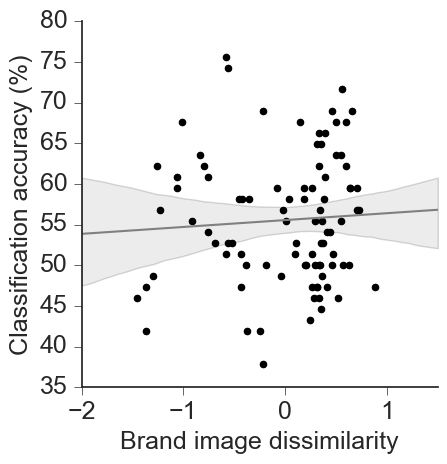

In [11]:
d = {'neural': z,#[np.mean(zz[zz[:,5]==m,4]) for m in range(14)], 
     'behave': np.array(all_res)*100 }#[np.mean(zz[zz[:,5]==m,3]) for m in range(14)]}
df = pd.DataFrame(data=d)
sns.reset_orig()
sns.set_style("ticks")
plt.rc('font', family='Arial',size=18)
sns.set_palette([(0.5,0.5,0.5),(0,0,0)],n_colors=1,desat=0.0)
sns.lmplot(x="neural", y="behave", data=df,markers='o')
plt.scatter(z, np.array(all_res)*100, color='k')
plt.xticks([-2,-1,0,1])
plt.ylabel("Classification accuracy (%)")
plt.xlabel("Brand image dissimilarity")
plt.savefig("classification_dissim.pdf",fmt='pdf')
plt.show()

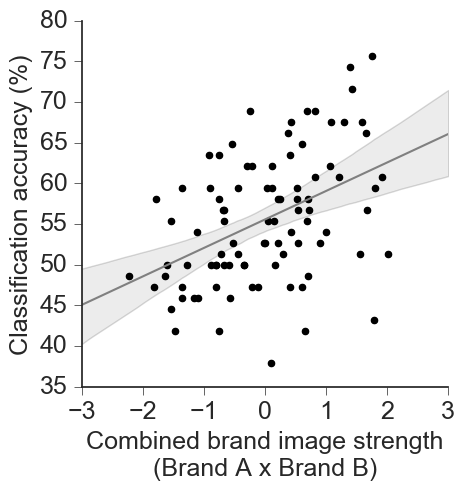

In [12]:
f_matrix_z = (f_matrix - np.mean(f_matrix))/np.std(f_matrix)

d = {'neural': f_matrix_z,#[np.mean(zz[zz[:,5]==m,4]) for m in range(14)], 
     'behave': np.array(all_res)*100}#[np.mean(zz[zz[:,5]==m,3]) for m in range(14)]}
df = pd.DataFrame(data=d)
sns.reset_orig()
sns.set_style("ticks")
plt.rc('font', family='Arial',size=18)
sns.set_palette([(0.5,0.5,0.5),(0,0,0)],n_colors=1,desat=0.0)

sns.lmplot(x="neural", y="behave", data=df,markers='o')
plt.plot([50,40],[50,50],'k--')

plt.scatter(f_matrix_z, np.array(all_res)*100, color='k')

plt.ylabel("Classification accuracy (%)")
plt.xlabel("Combined brand image strength\n(Brand A x Brand B)")
plt.savefig("classification_fam.pdf",fmt='pdf')

plt.show()